In [1]:
import os, sys
import numpy as np
import pandas as pd
import string
import keras.backend as K

Using TensorFlow backend.


In [2]:
MAX_TRAINING_SAMPLES = 10000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
LATENT_DIM = 128
BATCH_SIZE = 64
EPOCHS =30
VALIDATION_SPLIT=0.2

In [3]:
input_lines = []
target_lines = []
target_line_inputs = []

In [4]:
with open('spa.txt', encoding='utf-8') as f:
    text = f.readlines()

In [5]:
count = 0
for line in text:
    count+=1
    if count > MAX_TRAINING_SAMPLES:
        break
    
    if '\t' not in line:
        continue
        
    eng, translation, _ = line.rstrip().split('\t')
    
    target_line = translation + ' <eos>'
    target_input = '<sos> ' + translation
    
    input_lines.append(eng)
    target_lines.append(target_line)
    target_line_inputs.append(target_input)
    
print(f'Final samples collected: {len(input_lines)}')

Final samples collected: 10000


In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

eng_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
eng_tokenizer.fit_on_texts(input_lines)
input_sequences = eng_tokenizer.texts_to_sequences(input_lines)
eng_w2i = eng_tokenizer.word_index
print(f'Total {len(eng_w2i)} english words found')
max_eng_len = max(len(seq) for seq in input_sequences)
print(f'Input sequence maximum length: {max_eng_len}')

translate_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
translate_tokenizer.fit_on_texts(target_lines+target_line_inputs)
decoder_input_sequences = translate_tokenizer.texts_to_sequences(target_line_inputs)
decoder_output_sequences = translate_tokenizer.texts_to_sequences(target_lines)
translate_w2i = translate_tokenizer.word_index
print(f'Total {len(translate_w2i)} translated words found')
max_translate_len = max(len(seq) for seq in decoder_input_sequences)
print(f'Decoder sequence maximum length: {max_translate_len}')
max_translate_word = len(translate_w2i)+1
print(max_translate_word)

Total 2352 english words found
Input sequence maximum length: 5
Total 6325 translated words found
Decoder sequence maximum length: 9
6326


In [7]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_eng_len)
decoder_inputs = pad_sequences(decoder_input_sequences, maxlen=max_translate_len, padding='post')
decoder_outputs = pad_sequences(decoder_output_sequences, maxlen=max_translate_len, padding='post')
one_hot_decoder_outputs = np.zeros((len(input_lines), max_translate_len, max_translate_word))
for index, seq in enumerate(decoder_outputs):
    for i, word in enumerate(seq):
        one_hot_decoder_outputs[index, i, word] = 1

In [8]:
word2vec={}
for line in open(f'glove.6B.{EMBEDDING_DIM}d.txt', encoding='utf-8'):
    entry = line.split()
    word = entry[0]
    vector = np.asarray(entry[1:], dtype='float32')
    word2vec[word] = vector
print(f'Total {len(word2vec)} word vectors found')

Total 400000 word vectors found


In [9]:
max_eng_word = min(MAX_VOCAB_SIZE, len(eng_w2i)+1)
embedding_matrix = np.zeros((max_eng_word, EMBEDDING_DIM))
for word, index in eng_w2i.items():
    if index < MAX_VOCAB_SIZE:
        embedding_vector = eng_w2i.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

from keras.layers import Embedding
embedding_layer = Embedding(max_eng_word, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_eng_len)

In [10]:
from keras.models import Model, Input
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam

input_encoder = Input((max_eng_len,))
x = embedding_layer(input_encoder)
encoder = LSTM(LATENT_DIM, return_state=True)
encoder_output, h, c = encoder(x)
encoder_states = [h, c]

input_decoder = Input((max_translate_len,))
decoder_embedding = Embedding(max_translate_word, LATENT_DIM)
decoder_x = decoder_embedding(input_decoder)

decoder = LSTM(LATENT_DIM, return_state=True, return_sequences=True)
decoder_output, _, _ = decoder(decoder_x, initial_state=encoder_states)
decoder_dense_layer = Dense(max_translate_word, activation='softmax')
decoder_output = decoder_dense_layer(decoder_output)

model = Model([input_encoder, input_decoder], decoder_output)

In [11]:
def custom_loss(prediction, true):
    mask = K.cast(true>0, dtype='float32')
    output_log = mask*true*K.log(prediction)
    return -K.sum(output_log)/K.sum(mask)

def custom_accuracy(prediction, true):
    pred_labels = K.argmax(prediction, axis=-1)
    true_labels = K.argmax(true, axis=-1)
    match = K.cast(K.equal(true_labels, pred_labels), dtype='float32')
    
    mask = K.cast(K.greater(true_labels, 0), dtype='float32')
    out = mask*match
    return K.sum(out)/K.sum(mask)

In [12]:
#model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_accuracy])
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 100)       235300      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 9, 128)       809728      input_2[0][0]                    
____________________________________________________________________________________________

In [13]:
history = model.fit([encoder_inputs, decoder_inputs], one_hot_decoder_outputs, 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

C:\Users\Riju\Miniconda3\envs\Tensorflow-GPU\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 19s 2ms/step - loss: 2.5423 - accuracy: 0.6835 - val_loss: 2.4391 - val_accuracy: 0.6616
Epoch 2/30
8000/8000 [==============================] - 14s 2ms/step - loss: 1.8687 - accuracy: 0.7214 - val_loss: 2.4168 - val_accuracy: 0.6581
Epoch 3/30
8000/8000 [==============================] - 14s 2ms/step - loss: 1.7011 - accuracy: 0.7305 - val_loss: 2.4329 - val_accuracy: 0.6598
Epoch 4/30
8000/8000 [==============================] - 14s 2ms/step - loss: 1.5674 - accuracy: 0.7375 - val_loss: 2.4626 - val_accuracy: 0.6556
Epoch 5/30
8000/8000 [==============================] - 13s 2ms/step - loss: 1.4522 - accuracy: 0.7446 - val_loss: 2.5207 - val_accuracy: 0.6586
Epoch 6/30
8000/8000 [==============================] - 14s 2ms/step - loss: 1.3523 - accuracy: 0.7525 - val_loss: 2.5768 - val_accuracy: 0.6526
Epoch 7/30
8000/8000 [==============================] - 14s 2ms/step - loss: 1.270

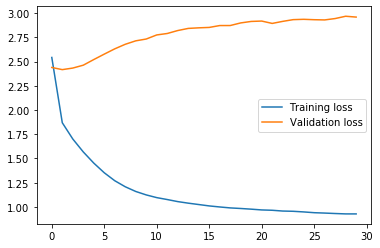

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

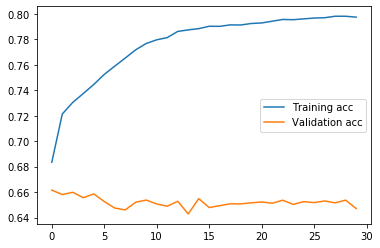

In [15]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.legend()
plt.show()

In [16]:
model.save('seq2seq.h5')

In [17]:
eng_i2w = {value: key for key, value in eng_w2i.items()}
translate_i2w = {value: key for key, value in translate_w2i.items()}

In [18]:
#### Prediction
encoder_model = Model(input_encoder, encoder_states)

decoder_initial_h = Input((LATENT_DIM,))
decoder_initial_c = Input((LATENT_DIM,))

decoder_input_states = [decoder_initial_h, decoder_initial_c]

decoder_input_pred = Input((1,))
decoder_x_pred = decoder_embedding(decoder_input_pred)

decoder_output_pred, h_pred, c_pred = decoder(decoder_x_pred, initial_state=decoder_input_states)
decoder_output_pred = decoder_dense_layer(decoder_output_pred)

decoder_model = Model([decoder_input_pred] + decoder_input_states, [decoder_output_pred] + [h_pred, c_pred])

In [19]:
def translator(eng_line):
    state_values = encoder_model.predict(eng_line)
    
    temp_pred = np.zeros((1,1))
    temp_pred[0,0] = translate_w2i['<sos>']
    
    eos = translate_w2i['<eos>']
    
    translation = []
    
    for _ in range(max_translate_len):
        output_, h_, c_ = decoder_model.predict([temp_pred] + state_values)
        
        maxp_idx = np.argmax(output_[0,0,:])
        if maxp_idx==eos:
            break
            
        word=''
        if maxp_idx>0:
            word = translate_i2w.get(maxp_idx)
            translation.append(word)
            
        temp_pred[0,0] = maxp_idx
        state_values = [h_,c_]
        
    return ' '.join(translation)

In [39]:
translator(encoder_inputs[2000:2001])

'yo no puedo manejar.'

In [42]:
target_lines[2000]

'Necesito esto. <eos>'